✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.
Loading data...
Dataset shape: (3513600, 9)
Feature columns: ['PM25_ug_m3', 'PM25_MERRA2', 'DUSMASS25', 'DUSMASS', 'location_encoded']
Number of features: 5
Using a subset of data for demonstration (first 20 locations)...
Creating sequences...
Total sequences: 7180
Training set shape: (5744, 168, 5)
Test set shape: (1436, 168, 5)


/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(



Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(5, 4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=4, out_features=1, bias=True)
)
Starting training with PyTorch...
Epoch 1/50 - Loss: 0.5464, Acc: 0.8656 - Val Loss: 0.4461, Val Acc: 0.9241 - Duration: 0.31s
  -> Validation loss improved. Saving model.
Epoch 2/50 - Loss: 0.3835, Acc: 0.9149 - Val Loss: 0.3194, Val Acc: 0.9262 - Duration: 0.33s
  -> Validation loss improved. Saving model.
Epoch 3/50 - Loss: 0.2879, Acc: 0.9239 - Val Loss: 0.2435, Val Acc: 0.9394 - Duration: 0.31s
  -> Validation loss improved. Saving model.
Epoch 4/50 - Loss: 0.2287, Acc: 0.9316 - Val Loss: 0.1952, Val Acc: 0.9485 - Duration: 0.32s
  -> Validation loss improved. Saving model.
Epoch 5/50 - Loss: 0.1896, Acc: 0.9392 - Val Loss: 0.1636, Val Acc: 0.9561 - Duration: 0.31s
  -> Validation loss improved. Saving model.
Epoch 6/50 - Loss: 0.1641, Acc: 0.9445 - Val Loss: 0.1448, Val Acc: 0.9582 - Duration: 0.33s
  -> Val

/tmp/ipykernel_72607/3696621561.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_classical_lstm_model.pth'))


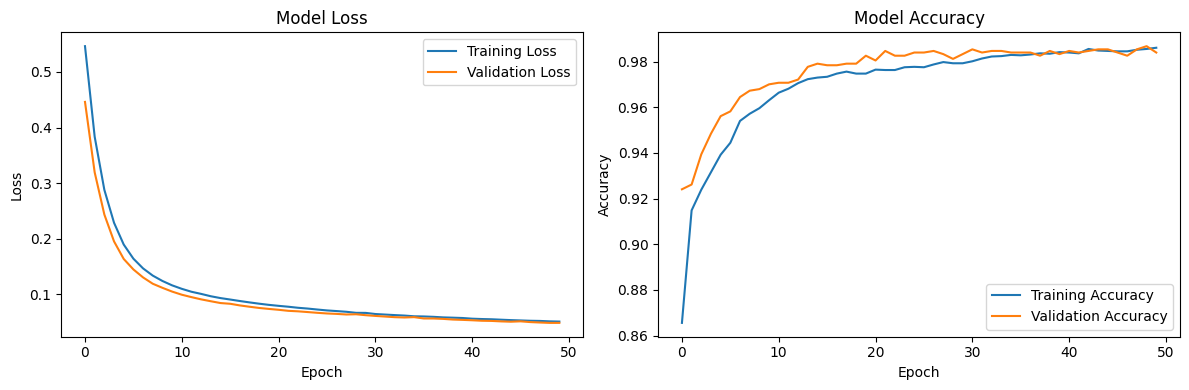


Generating predictions for visualization...

An error occurred: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (21).


Traceback (most recent call last):
  File "/tmp/ipykernel_72607/3696621561.py", line 310, in main
    plt.xticks(
  File "/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2239, in xticks
    labels_out = ax.set_xticklabels(labels, minor=minor, **kwargs)
  File "/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py", line 74, in wrapper
    return get_method(self)(*args, **kwargs)
  File "/home/abdelrahmanelsayed/.local/lib/python3.10/site-packages/matplotlib/axis.py", line 2106, in set_ticklabels
    raise ValueError(
ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (21).


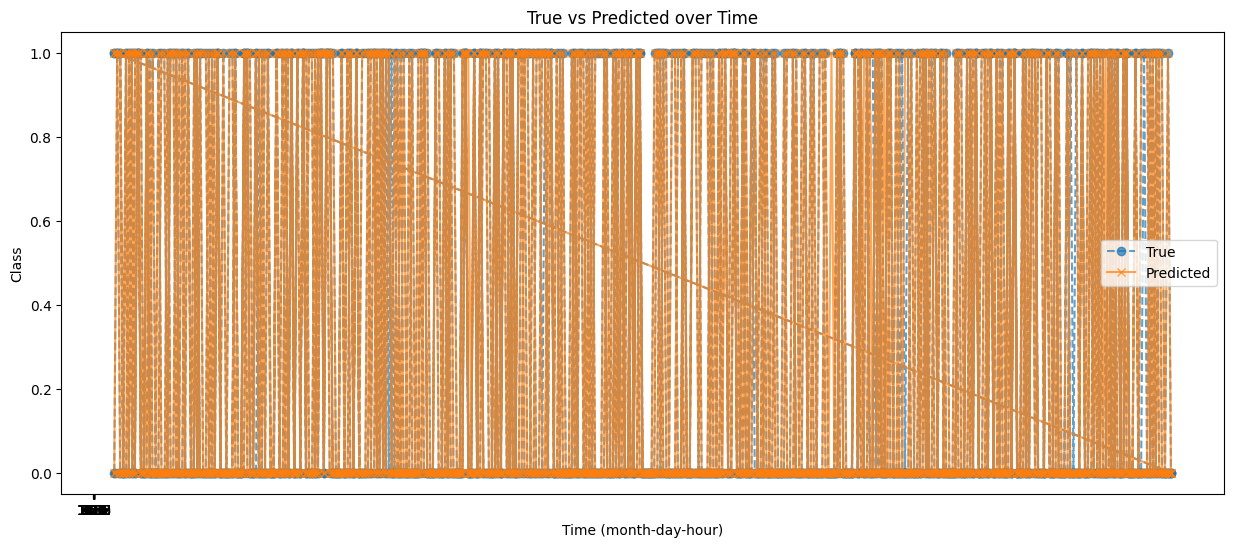

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

# --- Main Classical Model Architecture ---
class ClassicalLSTMModel(nn.Module):
    """
    Builds a purely classical LSTM model for time-series classification.
    This serves as a baseline to compare against the hybrid quantum model.
    """
    def __init__(self, n_features, n_lstm_units=16):
        super(ClassicalLSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=1,
            batch_first=True,
            dropout=0.2
        )
        
        self.classifier = nn.Linear(n_lstm_units, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_lstm_output = lstm_out[:, -1, :]
        output = self.classifier(final_lstm_output)
        return torch.sigmoid(output).squeeze()

# --- Data Handling ---
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_2024_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_2024_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_2024_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")
    
    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'month', 'day', 'hour'])
    
    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')
    
    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    return df, feature_columns, le_location

def create_sequences_memory_efficient(df, feature_columns, sequence_length=168, stride=24):
    """Create sequences. Input: 7 days (168h), Output: class of the next hour"""
    print("Creating sequences...")
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    
    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()
    
    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values
        
        for j in range(0, len(loc_df) - sequence_length, stride):
            X_seq = loc_X.iloc[j : j + sequence_length].values
            y_target = loc_y[j + sequence_length]
            
            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)
        
        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")
    
    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)
    
    print(f"Total sequences: {X_sequences.shape[0]}")
    return X_sequences, y_sequences, location_indices, scaler

# --- Model Training ---
def train_model_pytorch(model, train_loader, val_loader, epochs=10, patience=3):
    """Trains the PyTorch model."""
    print("Starting training with PyTorch...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    history = defaultdict(list)
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss, train_correct, train_samples = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            preds = (outputs > 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_samples += y_batch.size(0)
        
        train_loss /= train_samples
        train_acc = train_correct / train_samples
        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)

        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item() * X_batch.size(0)
                preds = (outputs > 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_samples += y_batch.size(0)

        val_loss /= val_samples
        val_acc = val_correct / val_samples
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        scheduler.step(val_loss)
        
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
              f"Duration: {epoch_duration:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_classical_lstm_model.pth')
            patience_counter = 0
            print("  -> Validation loss improved. Saving model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("  -> Early stopping triggered.")
                break
                
    model.load_state_dict(torch.load('best_classical_lstm_model.pth'))
    return model, history

# --- Plotting Training ---
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('classical_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Main Execution ---
def main():
    if torch.cuda.is_available():
        print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
    else:
        print("❌ No GPU found. The script will run on the CPU.")

    try:
        df, feature_columns, le_location = load_and_prepare_data()
        
        print("Using a subset of data for demonstration (first 20 locations)...")
        unique_locs_subset = df['location_encoded'].unique()[:20]
        df_subset = df[df['location_encoded'].isin(unique_locs_subset)]

        sequence_length = 168
        stride = 24

        X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
            df_subset, feature_columns, sequence_length=sequence_length, stride=stride
        )
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=location_indices
        )
        
        print(f"Training set shape: {X_train.shape}")
        print(f"Test set shape: {X_test.shape}")
        
        train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        del X_sequences, y_sequences, location_indices, X_train, X_test, y_train, y_test
        gc.collect()

        model = ClassicalLSTMModel(n_features=len(feature_columns), n_lstm_units=4)
        print("\nClassical LSTM Model Architecture:")
        print(model)
        
        model, history = train_model_pytorch(model, train_loader, val_loader, epochs=50, patience=5)
        
        plot_training_history(history)
        
        # -------------------------------
        # Predictions & Time Alignment
        # -------------------------------
        print("\nGenerating predictions for visualization...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        all_preds, all_trues = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                preds = model(X_batch).cpu().numpy()
                all_preds.extend(preds)
                all_trues.extend(y_batch.numpy())

        all_preds = np.array(all_preds)
        all_trues = np.array(all_trues)
        pred_classes = (all_preds > 0.5).astype(int)

        # Align predictions with time info
        df_eval = df_subset.copy()
        df_eval["true_class"] = np.nan
        df_eval["pred_class"] = np.nan

        idx = 0
        for loc in df_eval["location_encoded"].unique():
            loc_df = df_eval[df_eval["location_encoded"] == loc]
            loc_idx = loc_df.index

            for j in range(0, len(loc_df) - sequence_length, stride):
                if idx >= len(all_trues):
                    break
                target_index = loc_idx[j + sequence_length]
                df_eval.loc[target_index, "true_class"] = all_trues[idx]
                df_eval.loc[target_index, "pred_class"] = pred_classes[idx]
                idx += 1

        df_eval = df_eval.dropna(subset=["true_class", "pred_class"])

        # Plot True vs Predicted
        plt.figure(figsize=(15, 6))
        plt.plot(
            df_eval.index,
            df_eval["true_class"],
            label="True",
            marker="o",
            linestyle="--",
            alpha=0.7
        )
        plt.plot(
            df_eval.index,
            df_eval["pred_class"],
            label="Predicted",
            marker="x",
            alpha=0.7
        )
        plt.xlabel("Time (month-day-hour)")
        plt.ylabel("Class")
        plt.title("True vs Predicted over Time")
        plt.legend()

        time_labels = df_eval[["month", "day", "hour"]].astype(str).agg("-".join, axis=1)
        plt.xticks(
            ticks=np.linspace(0, len(df_eval)-1, 20, dtype=int),
            labels=time_labels.iloc[::len(df_eval)//20],
            rotation=45
        )

        plt.tight_layout()
        plt.savefig("true_vs_predicted.png", dpi=300)
        plt.show()

        print("\n✅ Classical LSTM training and evaluation completed successfully!")

    except Exception as e:
        print(f"\nAn error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == '__main__':
    main()


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pennylane as qml
from pennylane import numpy as pnp

import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time

In [24]:
n_qubits = 4 
n_layers = 1  

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev = qml.device("lightning.qubit", wires=n_qubits)

In [26]:
@qml.qnode(dev, interface="torch")
def q_circuit(inputs, weights):
    """A simple quantum circuit that acts as a classifier."""
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

In [27]:
class QLSTMModel(nn.Module):
    """
    Builds a more efficient hybrid Quantum-Classical model.
    A classical LSTM processes the sequence, and its output is fed
    into a single quantum circuit for classification.
    """
    def __init__(self, n_features, n_lstm_units=8, n_qubits=4, n_layers=1):
        super(QLSTMModel, self).__init__()
        
        # 1. Classical LSTM Layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=1,
            batch_first=True # This is important!
        )
        
        # 2. Classical Layer to map LSTM output to Quantum input
        self.classical_to_quantum = nn.Linear(n_lstm_units, n_qubits)

        # 3. Quantum Layer
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(q_circuit, weight_shapes)

    def forward(self, x):  
        # 1. Pass data through the classical LSTM
        lstm_out, _ = self.lstm(x)
        
        # 2. We are interested in the features from the very last timestep
        final_lstm_output = lstm_out[:, -1, :]
        
        # 3. Prepare the data for the quantum circuit
        quantum_input = self.classical_to_quantum(final_lstm_output)
        
        # 4. Pass the features through the quantum circuit
        quantum_output = self.q_layer(quantum_input) # Shape: (batch_size, 1)

        # 5. Apply sigmoid activation to get a probability
        return torch.sigmoid(quantum_output).squeeze()

In [28]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    if not os.path.exists('air_quality_2024_preproccessed.parquet'):
        raise FileNotFoundError("The data file 'air_quality_2024_preproccessed.parquet' was not found.")
    df = pq.read_table('air_quality_2024_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")
    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    df = df.sort_values(['location_encoded', 'month', 'day', 'hour'])
    feature_columns = [col for col in df.columns if col not in ['class', 'location', 'month', 'day', 'hour', 'location_encoded']]
    feature_columns.append('location_encoded')
    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    return df, feature_columns, le_location

In [29]:
def create_sequences_memory_efficient(df, feature_columns, sequence_length=168, stride=24):
    """Create sequences with memory optimizations. Input: 7 days (168h), Output: 3 days (72h)"""
    print("Creating sequences...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    X_sequences, y_sequences, location_indices = [], [], []
    unique_locations = df['location_encoded'].unique()
    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values
        for j in range(0, len(loc_df) - sequence_length - 72 + 1, stride):
            X_seq = loc_X.iloc[j : j + sequence_length].values
            y_target = loc_y[j + sequence_length]
            X_sequences.append(X_seq)
            y_sequences.append(y_target)
            location_indices.append(loc)
        if (i+1) % 100 == 0:
            print(f"Processed location {i+1}/{len(unique_locations)}")
    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.float32)
    location_indices = np.array(location_indices)
    print(f"Total sequences: {X_sequences.shape[0]}")
    return X_sequences, y_sequences, location_indices, scaler

In [32]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

try:
    df, feature_columns, le_location = load_and_prepare_data()
    
    print("Using a subset of data for demonstration (first 20 locations)...")
    unique_locs_subset = df['location_encoded'].unique()[:20]
    df_subset = df[df['location_encoded'].isin(unique_locs_subset)]

    # The target is now a single value (next hour's class), not a 72-hour sequence
    X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
        df_subset, feature_columns, sequence_length=168, stride=24
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=location_indices
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    
    # We can use a larger batch size now
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    del X_sequences, y_sequences, location_indices, X_train, X_test, y_train, y_test
    gc.collect()

    model = QLSTMModel(n_features=len(feature_columns), n_lstm_units=4, n_qubits=4)
    print("\nNew, Faster Model Architecture:")
    print(model)
    
    model, history = train_model_pytorch(model, train_loader, val_loader, epochs=30, patience=5)
    
    print("\nEfficient Hybrid LSTM training with PyTorch completed successfully!")
    
except Exception as e:
    print(f"\nAn error occurred: {e}")
    import traceback
    traceback.print_exc()

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.
Loading data...
Dataset shape: (3513600, 9)
Feature columns: ['PM25_ug_m3', 'PM25_MERRA2', 'DUSMASS25', 'DUSMASS', 'location_encoded']
Number of features: 5
Using a subset of data for demonstration (first 20 locations)...
Creating sequences...
Total sequences: 7140
Training set shape: (5712, 168, 5)
Test set shape: (1428, 168, 5)

New, Faster Model Architecture:
QLSTMModel(
  (lstm): LSTM(5, 4, batch_first=True)
  (classical_to_quantum): Linear(in_features=4, out_features=4, bias=True)
  (q_layer): <Quantum Torch Layer: func=q_circuit>
)
Starting training with PyTorch...
Epoch 1/30 - Loss: 0.6152, Acc: 0.6821 - Val Loss: 0.5593, Val Acc: 0.6772 - Duration: 19.27s
  -> Validation loss improved. Saving model.
Epoch 2/30 - Loss: 0.5110, Acc: 0.8050 - Val Loss: 0.4563, Val Acc: 0.9244 - Duration: 19.19s
  -> Validation loss improved. Saving model.
Epoch 3/30 - Loss: 0.4247, Acc: 0.9210 - Val Loss: 0.3905, Val Acc: 0.9384 - Durati

/tmp/ipykernel_72607/3101846423.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_qlstm_model_fast.pth'))
